# 预测波士顿房价

## 在 SageMaker 中使用 XGBoost（批转换）

_机器学习工程师纳米学位课程 | 开发_

---

为了介绍 SageMaker 的低阶 Python API，我们将查看一个相对简单的问题。我们将使用[波士顿房价数据集](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)预测波士顿地区的房价中位数。

此 notebook 中使用的 API 的参考文档位于 [SageMaker 开发人员指南](https://docs.aws.amazon.com/sagemaker/latest/dg/)页面

## 一般步骤

通常，在 notebook 实例中使用 SageMaker 时，你需要完成以下步骤。当然，并非每个项目都要完成每一步。此外，有很多步骤有很大的变化余地，你将在这些课程中发现这一点。

1. 下载或检索数据。
2. 处理/准备数据。
3. 将处理的数据上传到 S3。
4. 训练所选的模型。
5. 测试训练的模型（通常使用批转换作业）。
6. 部署训练的模型。
7. 使用部署的模型。

在此 notebook 中，我们将仅介绍第 1-5 步，因为只是大致了解如何使用 SageMaker。在后面的 notebook 中，我们将详细介绍如何部署训练的模型。

## 第 0 步：设置 notebook

先进行必要的设置以运行 notebook。首先，加载所需的所有 Python 模块。

In [1]:
%matplotlib inline

import os

import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

除了上面的模块之外，我们还需要导入将使用的各种 SageMaker 模块。

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## 第 1 步：下载数据

幸运的是，我们可以使用 sklearn 检索数据集，所以这一步相对比较简单。

In [3]:
boston = load_boston()

## 第 2 步：准备和拆分数据

因为使用的是整洁的表格数据，所以不需要进行任何处理。但是，我们需要将数据集中的各行拆分成训练集、测试集和验证集。

In [4]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## 第 3 步：将数据文件上传到 S3

使用 SageMaker 创建训练作业后，进行训练操作的容器会执行。此容器可以访问存储在 S3 上的数据。所以我们需要将用来训练的数据上传到 S3。此外，在执行批转换作业时，SageMaker 要求输入数据存储在 S3 上。我们可以使用 SageMaker API 完成这一步，它会在后台自动处理完一些步骤。

### 将数据保存到本地

首先，我们需要创建测试、训练和验证 csv 文件，并将这些文件上传到 S3。

In [5]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
# We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### 上传到 S3

因为目前正在 SageMaker 会话中运行，所以可以使用代表此会话的对象将数据上传到默认的 S3 存储桶中。注意，建议提供自定义 prefix（即 S3 文件夹），以防意外地破坏了其他 notebook 或项目上传的数据。

In [7]:
prefix = 'boston-xgboost-LL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## 第 4 步：训练和构建 XGBoost 模型

将训练和验证数据上传到 S3 后，我们可以为 XGBoost 模型创建训练作业并构建模型本身了。

### 设置训练作业

首先，我们将为模型设置和执行训练作业。我们需要指定一些信息，供 SageMaker 设置和正确地执行计算过程。要查看构建训练作业的其他文档，请参阅 [CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html) 参考文档。

In [8]:
# We will need to know the name of the container that we want to use for training. SageMaker provides
# a nice utility method to construct this for us.
container = get_image_uri(session.boto_region_name, 'xgboost')

# We now specify the parameters we wish to use for our training job
training_params = {}

# We need to specify the permissions that this training job will have. For our purposes we can use
# the same permissions that our current SageMaker session has.
training_params['RoleArn'] = role

# Here we describe the algorithm we wish to use. The most important part is the container which
# contains the training code.
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# We also need to say where we would like the resulting model artifacts stored.
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# We also need to set some parameters for the training job itself. Namely we need to describe what sort of
# compute instance we wish to use along with a stopping condition to handle the case that there is
# some sort of error and the training script doesn't terminate.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

# Next we set the algorithm specific hyperparameters. You may wish to change these to see what effect
# there is on the resulting model.
training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# Now we need to tell SageMaker where the data should be retrieved from.
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

	get_image_uri(region, 'xgboost', '0.90-1').


### 执行训练作业

构建了包含训练作业参数的字典对象后，我们可以要求 SageMaker 执行训练作业了。

In [9]:
# First we need to choose a training job name. This is useful for if we want to recall information about our
# training job at a later date. Note that SageMaker requires a training job name and that the name needs to
# be unique, which we accomplish by appending the current timestamp.
training_job_name = "boston-xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

SageMaker 已经创建了训练作业，并且训练作业现在正在运行中。因为我们需要获得训练作业的输出，所以需要等待运行完毕。我们可以要求 SageMaker 输出训练作业生成的日志，并继续要求输出日志，直到训练作业运行完毕。

In [10]:
session.logs_for_job(training_job_name, wait=True)

2020-03-25 12:01:56 Starting - Starting the training job...
2020-03-25 12:01:58 Starting - Launching requested ML instances......
2020-03-25 12:02:57 Starting - Preparing the instances for training...
2020-03-25 12:03:56 Downloading - Downloading input data...
2020-03-25 12:04:12 Training - Downloading the training image.Arguments: train
[2020-03-25:12:04:32:INFO] Running standalone xgboost training.
[2020-03-25:12:04:32:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8512.15mb
[2020-03-25:12:04:32:INFO] Determined delimiter of CSV input is ','
[12:04:32] S3DistributionType set as FullyReplicated
[12:04:32] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-03-25:12:04:32:INFO] Determined delimiter of CSV input is ','
[12:04:32] S3DistributionType set as FullyReplicated
[12:04:32] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&d

### 构建模型

训练作业运行完毕后，我们可以使用一些模型工件构建模型。注意，我们说的模型是 SageMaker 所定义的模型，即关于特定算法及其训练作业生成的工件的信息集合。

In [11]:
# We begin by asking SageMaker to describe for us the results of the training job. The data structure
# returned contains a lot more information than we currently need, try checking it out yourself in
# more detail.
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [12]:
# Just like when we created a training job, the model name must be unique
model_name = training_job_name + "-model"

# We also need to tell SageMaker which container should be used for inference and where it should
# retrieve the model artifacts from. In our case, the xgboost container that we used for training
# can also be used for inference.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# And lastly we construct the SageMaker model
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

## 第 5 步：测试模型

将模型拟合训练数据并使用验证数据避免过拟合后，我们可以测试模型了。我们将使用 SageMaker 的批转换功能。也就是说，我们需要设置和执行批转换作业，与之前构建训练作业的方式相似。

### 设置批转换作业

就像训练模型一样，我们首先需要提供一些信息，并且所采用的数据结构描述了我们要执行的批转换作业。

我们将仅使用这里可用的某些选项，如果你想了解其他选项，请参阅[创建批转换作业](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTransformJob.html) SageMaker 文档。

In [13]:
# Just like in each of the previous steps, we need to make sure to name our job and the name should be unique.
transform_job_name = 'boston-xgboost-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Now we construct the data structure which will describe the batch transform job.
transform_request = \
{
    "TransformJobName": transform_job_name,
    
    # This is the name of the model that we created earlier.
    "ModelName": model_name,
    
    # This describes how many compute instances should be used at once. If you happen to be doing a very large
    # batch transform job it may be worth running multiple compute instances at once.
    "MaxConcurrentTransforms": 1,
    
    # This says how big each individual request sent to the model should be, at most. One of the things that
    # SageMaker does in the background is to split our data up into chunks so that each chunks stays under
    # this size limit.
    "MaxPayloadInMB": 6,
    
    # Sometimes we may want to send only a single sample to our endpoint at a time, however in this case each of
    # the chunks that we send should contain multiple samples of our input data.
    "BatchStrategy": "MultiRecord",
    
    # This next object describes where the output data should be stored. Some of the more advanced options which
    # we don't cover here also describe how SageMaker should collect output from various batches.
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)
    },
    
    # Here we describe our input data. Of course, we need to tell SageMaker where on S3 our input data is stored, in
    # addition we need to detail the characteristics of our input data. In particular, since SageMaker may need to
    # split our data up into chunks, it needs to know how the individual samples in our data file appear. In our
    # case each line is its own sample and so we set the split type to 'line'. We also need to tell SageMaker what
    # type of data is being sent, in this case csv, so that it can properly serialize the data.
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },
    
    # And lastly we tell SageMaker what sort of compute instance we would like it to use.
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

### 执行批转换作业

创建了请求数据结构后，下面要求 SageMaker 设置和运行批转换作业。与之前的步骤一样，SageMaker 会在后台执行这些任务，如果你想等待转换作业运行完毕（并查看作业的进度），可以调用 wait() 方法来等待转换作业运行完毕。

In [14]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)

In [15]:
transform_desc = session.wait_for_transform_job(transform_job_name)

................................................!


### 分析结果

现在转换作业已经运行完毕，结果按照我们的要求存储到了 S3 上。因为我们想要在 notebook 中分析输出结果，所以将使用一个 notebook 功能将输出文件从 S3 复制到本地。

In [16]:
transform_output = "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)

In [17]:
!aws s3 cp --recursive $transform_output $data_dir

download: s3://sagemaker-us-west-1-270372225889/boston-xgboost-LL/batch-bransform/test.csv.out to ../data/boston/test.csv.out


为了查看模型的运行效果，我们可以绘制一个简单的预测值与真实值散点图。如果模型的预测完全准确的话，那么散点图将是一条直线 $x=y$。可以看出，我们的模型表现不错，但是还有改进的余地。

In [18]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5, 1.0, 'Median Price vs Predicted Price')

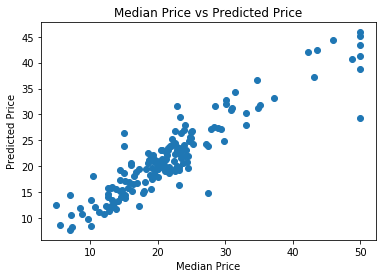

In [19]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## 可选步骤：清理数据

SageMaker 上的默认 notebook 实例没有太多的可用磁盘空间。当你继续完成和执行 notebook 时，最终会耗尽磁盘空间，导致难以诊断的错误。完全使用完 notebook 后，建议删除创建的文件。你可以从终端或 notebook hub 删除文件。以下单元格中包含了从 notebook 内清理文件的命令。

In [20]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir